In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime as dt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
%matplotlib inline
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [2]:

# Models from Scikit-Learn
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations

from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score


In [3]:
df = pd.read_csv('2015 CSCS20 - Rafał Stybliński (1)/EURUSD_Candlestick_15_m_BID_03.06.2013-28.06.2013.csv')


In [4]:
df.head()

,Time,Open,High,Low,Close,Volume
0,03.06.2013 00:00:00.000,1.29944,1.29955,1.29870,1.29904,941.71
1,03.06.2013 00:15:00.000,1.29904,1.29964,1.29904,1.29964,869.10
2,03.06.2013 00:30:00.000,1.29964,1.30015,1.29960,1.29977,855.04
3,03.06.2013 00:45:00.000,1.29977,1.30065,1.29972,1.30043,1067.18
4,03.06.2013 01:00:00.000,1.30043,1.30043,1.29911,1.29978,1372.88


In [5]:
df['Time']

0       03.06.2013 00:00:00.000
1       03.06.2013 00:15:00.000
2       03.06.2013 00:30:00.000
3       03.06.2013 00:45:00.000
4       03.06.2013 01:00:00.000
                 ...           
2491    28.06.2013 22:45:00.000
2492    28.06.2013 23:00:00.000
2493    28.06.2013 23:15:00.000
2494    28.06.2013 23:30:00.000
2495    28.06.2013 23:45:00.000
Name: Time, Length: 2496, dtype: object

In [6]:
df['Time'] = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S.%f')

In [7]:
df['Time'] = df['Time'].map(lambda x: x.strftime('%Y-%m-%d'))

In [8]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d')

#
# datetime.strptime(df[Time], '%y/%d/%m %H:%M:%S')

In [9]:
df = df.set_index('Time')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2496 entries, 2013-06-03 to 2013-06-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2496 non-null   float64
 1   High    2496 non-null   float64
 2   Low     2496 non-null   float64
 3   Close   2496 non-null   float64
 4   Volume  2496 non-null   float64
dtypes: float64(5)
memory usage: 117.0 KB


In [11]:
df.head()

,Open,High,Low,Close,Volume
Time,,,,,
2013-06-03,1.29944,1.29955,1.29870,1.29904,941.71
2013-06-03,1.29904,1.29964,1.29904,1.29964,869.10
2013-06-03,1.29964,1.30015,1.29960,1.29977,855.04
2013-06-03,1.29977,1.30065,1.29972,1.30043,1067.18
2013-06-03,1.30043,1.30043,1.29911,1.29978,1372.88


In [12]:
df.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

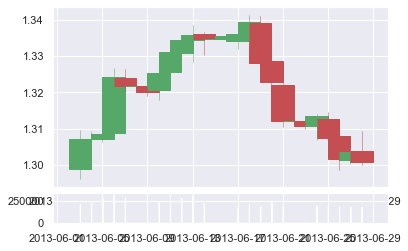

In [13]:
sns.set_theme(style="darkgrid")


df_ohlc= df['Close'].resample('15T').ohlc()
df_volume=df['Volume'].resample('15T').sum()
df_ohlc.reset_index(inplace=True)
df_ohlc['Time']=df_ohlc['Time'].map(mdates.date2num)



ax1=plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2=plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1 , sharex=ax1)
ax1.xaxis_date()

candlestick_ohlc(ax1,df_ohlc.values, width=2, colorup='g')
ax2.fill_between(df_volume.index.map(mdates.date2num),df_volume.values,0)


<AxesSubplot:xlabel='Time'>

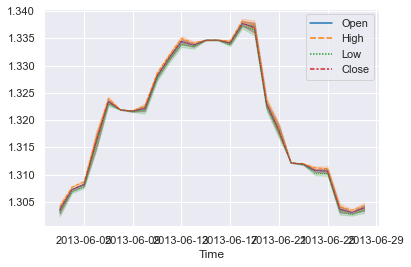

In [14]:
sns.set_theme(style="darkgrid")
dfRate = df.drop(['Volume'], axis=1)

sns.lineplot(data=dfRate, palette="tab10", linewidth=1)



In [15]:
df2 = df.drop(['Volume', 'Open', 'High', 'Low', 'Volume'], axis=1)

In [16]:

df2.tail()

,Close
Time,
2013-06-28,1.30096
2013-06-28,1.30096
2013-06-28,1.30096
2013-06-28,1.30096
2013-06-28,1.30096


<AxesSubplot:xlabel='Time'>

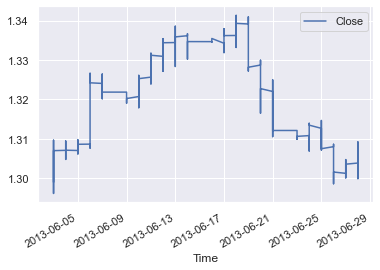

In [17]:
df2.plot()

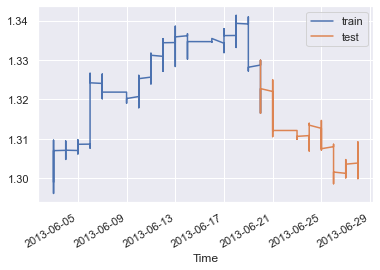

In [18]:
split_date = pd.Timestamp('2013-06-20')

train = df2.loc[:split_date]
test = df2.loc[split_date:]

ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [19]:
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [20]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [21]:
import os
os.getcwd()
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

In [22]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
history = model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, callbacks=[early_stop], shuffle=False)

Epoch 1/200
1727/1727 [==============================] - 1s 600us/step - loss: 0.0038

In [23]:
y_pred_test_ann = model.predict(X_test)
y_train_pred_ann = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_ann)))
r2_train = r2_score(y_train, y_train_pred_ann)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_ann)))
r2_test = r2_score(y_test, y_pred_test_ann)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

The R2 score on the Train set is:	0.971
The Adjusted R2 score on the Train set is:	0.971

The R2 score on the Test set is:	0.910
The Adjusted R2 score on the Test set is:	0.910


In [24]:
model.save('ANN_NonShift.h5')

In [25]:
X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [26]:
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(7, input_shape=(1, X_train.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)
print("The Adjusted R2 score on the Train set is:\t{:0.3f}\n".format(adj_r2_score(r2_train, X_train.shape[0], X_train.shape[1])))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)
print("The Adjusted R2 score on the Test set is:\t{:0.3f}".format(adj_r2_score(r2_test, X_test.shape[0], X_test.shape[1])))

Epoch 1/200
1727/1727 [==============================] - 2s 819us/step - loss: 0.0023

In [27]:
model_lstm.save('LSTM_NonShift.h5')

In [28]:

model_ann = load_model('ANN_NonShift.h5')
model_lstm = load_model('LSTM_NonShift.h5')

In [29]:
score_ann= model_ann.evaluate(X_test, y_test, batch_size=1)
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

863/863 [==============================] - 1s 812us/step - loss: 0.0018


In [30]:
print('ANN: %f'%score_ann)
print('LSTM: %f'%score_lstm)


ANN: 0.002037
LSTM: 0.001845


In [31]:

y_pred_test_ANN = model_ann.predict(X_test)
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

In [32]:
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_ANN, columns=['ANN_prediction'])
col3 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col4 = pd.DataFrame(history.history['loss'], columns=['Loss_ANN'])
col5 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3, col4, col5], axis=1)
results.to_excel('PredictionResults_ANN-LSTM_NonShift.xlsx')

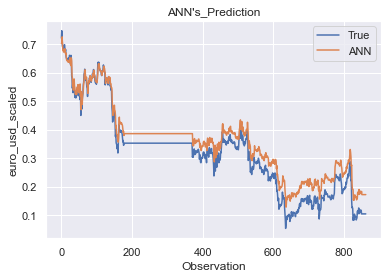

In [33]:

plt.plot(y_test, label='True')
plt.plot(y_pred_test_ANN, label='ANN')
plt.title("ANN's_Prediction")
plt.xlabel('Observation')
plt.ylabel('euro_usd_scaled')
plt.legend()
plt.show()

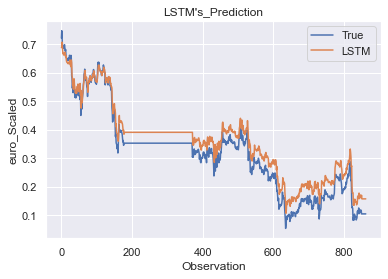

In [34]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('euro_Scaled')
plt.legend()
plt.show()